High level plan:
1. Gather data:
    - 1.1: Find the person's social links, then scrape them
    - 1.2: Find wikipedia articles about the person
    - 1.3: (TODO) Find interviews with the person, then drill into those interviews and extract only the interview content
2. Taking the data gathered in step 1, produce the AI Chatbot's prompt/details
    - 2.1: Eliza/Autonome prompt creator
        - Using LLM generated AI specialists, generate bio, lore, topics, style, post examples, message examples, adjectives, known people based on research from step 1
        - Generate a compatible [JSON file for Eliza](https://github.com/elizaOS/eliza/blob/develop/characters/c3po.character.json). The contents of this file can be used to populate Autonome (Autonome is just an interface for Eliza)
3. (TODO) Deploy the personality chatbot:
    - (TODO) Actually deploy the AI chatbot to Autonome, Gold Rush
    - (TODO) Deploy the AI chatbot to local Eliza or Eliza on local network


# IMPORTS AND SETUP, RUN ME FIRST

In [1]:
import os
import uuid
from pprint import pprint
from typing import Annotated, Dict, List, TypedDict, Literal, Union, Any

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_anthropic import ChatAnthropic
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from pydantic import BaseModel, Field
from tools.bluesky.models import (
    BlueskyPost,
    BlueskyProfile,
    BlueskyReply,
    BlueskyRepost,
    BlueskyThread,
)
from tools.bluesky.utils import reduce_bluesky_posts, reduce_bluesky_replies
from tools.bluesky.get_profile import get_profile
from tools.bluesky.get_author_feed import get_author_feed
from tools.common import reduce_dict_merge
load_dotenv()




# Step 1: SOCIAL READER GRAPH
1. Find the person's social links to Blue Sky, Facebook, X, etc.
    1. Find the person's social links to Blue Sky, Facebook, X, etc.
    1. For each social link source, scrape and extract the content. Details on behavior for each supported social link source are below.
        - Blue Sky: 
            - Scrape last 100 (default) posts, replies, and reposts with the API
        - Get the messages leading up to a reply (expensive, keep post limit low to avoid rate limiting)
        - (TODO) Facebook:
        - (TODO) X:
            - Selenium lol
            - Not currently integrated with the agent, only have a POC generation
1.4 Fetch the person's interviews, articles, books, etc. for the biography generation
**Note: This agent is only designed to fetch content, processing the content is done in the next major phase of the main graph**


## Shared state
State is shared among subgraphs w/ overlapping keys. By having all subgraphs in this step share the same key, we don't have to worry about merging the states in a custom reducer

## Step 1.1: Gather user's social links

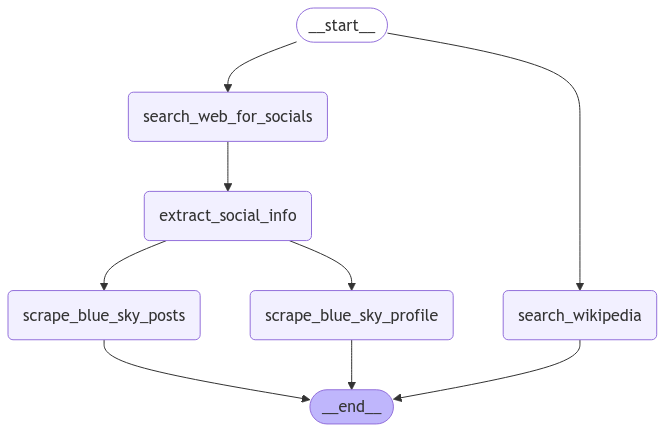

In [4]:
from IPython.display import Image, display
from research_graph import research_agent

display(Image(research_agent.get_graph(xray=True).draw_mermaid_png()))

### Example call for social search

In [5]:
from research_graph import research_agent
from langchain_core.messages import HumanMessage
from pprint import pprint
# Example calls for social searh
state = research_agent.invoke({"messages": [HumanMessage(content="Mark Cuban")]})
pprint(state.values)
print("----------------")
research = state.get("research")
pprint(research)
print("----------------")
print("Socials")
socials = research.get("socials")
# print(f"X Handle: {socials.x_username}")
print(f"X URL: {socials.x_page}")
# print(f"Facebook Handle: {socials.facebook_username}")
print(f"Facebook URL: {socials.facebook_page}")
# print(f"Bluesky Handle: {socials.bluesky_handle}")
print(f"Bluesky URL: {socials.bluesky_page}")
# print(f"Instagram Handle: {socials.instagram_username}")
print(f"Instagram URL: {socials.instagram_page}")
# print(f"LinkedIn Handle: {socials.linkedin_username}")
print(f"LinkedIn URL: {socials.linkedin_page}")
# print(f"TikTok Handle: {socials.tiktok_username}")
print(f"TikTok URL: {socials.tiktok_page}")
# print(f"Truth Social Handle: {socials.truth_social_username}")
print(f"Truth Social URL: {socials.truth_social_page}")
# print(f"YouTube Handle: {socials.youtube_username}")
print(f"YouTube URL: {socials.youtube_page}")
print("--------------------------------")
print("bluesky_profile:", research.get("bluesky_profile"))
print("bluesky_posts:", research.get("bluesky_posts"))
print("bluesky_replies:", research.get("bluesky_replies"))
print("bluesky_reposts:", research.get("bluesky_reposts"))

Preparing search queries for social media pages
type of social_search_queries.search_queries <class 'list'>
Searching for Mark Cuban BlueSky page
type of search_docs <class 'list'>
type of search_docs[0] <class 'dict'>
search_docs[0] {'url': 'https://www.benzinga.com/general/social-media/24/12/42566461/mark-cuban-says-this-is-the-holy-grail-that-makes-bluesky-better-than-musks-x-platform', 'content': "Mark Cuban Says This Is The 'Holy Grail' That Makes Bluesky Better Than Musk's X Platform - Meta Platforms (NASDAQ:META) - Benzinga Calendars Mark Cuban Says This Is The 'Holy Grail' That Makes Bluesky Better Than Musk's X Platform Mark Cuban is one of the most followed people on social media platform Bluesky. Mark Cuban is one of the most followed people on social media platform Bluesky. In a recent interview, Cuban shares what sets Bluesky apart from X and why he's spending more time there. During a recent interview with Jules Terpak, Cuban discussed the current climate of social media 

## Step 1.2 WIKIPEDIA SEARCH

Used to get source material for the biography when we generate the Agent prompt. We need a more comprehensive set of sources later, but this is fine for a demo.


### Example call for wikipedia search

In [ ]:
state = wikipedia_graph.invoke({"messages": [HumanMessage(content="Mark Cuban")]})
research = state.get("research")
print(f"Wikipedia query: {research.get('wikipedia_query')}")
print(f"Wikipedia search results: {research.get('wikipedia_search_results')}")


# (TODO) Step 1.3: Article/interview/book search

Later we will want to do a Tavily search and scrape bio information from interviews, book summaries, articles, etc.
This breadth of search would quickly dry up our free tier credits, so we will omit this search for now and just use wikipedia.



In [36]:
# Drafts, not fully written
interview_finder_sys_msg = """You are doing research on {public_figure}

Your goal is to form well structured web search queries that can be used to find interviews with the public figure so we can get a handle on their speaking style and public persona.

Respond with the search queries in a list, and nothing else."""


def article_interview_wiki_finder(public_figure, topic, time_period, is_real_person):
    article_finder_sys_msg = """
    You will be given the name of a public figure, and will optionally be given a topic and time period.

    Your goal is to form well structured web search queries to find the following articles and information about the public figure. 
    If you are given a topic, your search query should be focused on finding articles and information for that topic. 
    If you are given a time period, your search query should be focused on finding articles and information for that time period.:
    If {public_figure} is a real person, you should search for wikis, articles, interviews, books, and op-eds.
    If {public_figure} is a fictional character, you do not need to search for interviews, books, or op-eds, and should instead search for wikis, articles, reviews, reddit threads, and blog posts.

    Below is the name of the public figure, the optional topic, the optional time period, and whether or not the public figure is a real person or a fictional character.
    <input>
        <public_figure>
            {public_figure}
        </public_figure>
        <topic>
            {topic}
        </topic>
        <time_period>
            {time_period}
        </time_period>
        <fictional_character>
            {fictional_character}
        </fictional_character>
    </input>

    Respond with the search queries in a list, and nothing else."""

# STEP 2: Create agent prompts




## Step 2.1: Generate Eliza agent prompt
Requires research from step 1, and generates [a character card for Autonome](https://github.com/elizaOS/eliza/blob/develop/characters/c3po.character.json)

1. Take the research from step 1 and generate data for the following fields on Autonome's Eliza form (descriptions are from the helper text on the Eliza form):
    - Character details:
        - BIO: "Provide a detailed biography of the character, including their background, life experiences, and key personality traits. Write one complete sentence per line."
        - LORE: "Detail the character's universe, background, and significant events that influenced them. Write one complete sentence per line."
        - TOPICS: "Enumerate the subjects the character is well-versed in or passionate about. Write one complete sentence per line."
    - Style:
        - GENERAL STYLE: "Outline the character's overall communication style. Mention speech patterns, mannerisms, and common expressions. Write one complete sentence per line."
        - CHAT STYLE: "Explain the character's conversational behavior. Include typical responses and chat-specific quirks. Write one complete sentence per line."
        - POST STYLE: "Detail the character's approach to writing posts or longer content. Include their formatting preferences and overall writing style. Write one complete sentence per line."
    - Examples:
        - POST EXAMPLES: "Provide sample posts showcasing the character's writing style. Include various types of content they might produce. Write each post on a new line."
        - MESSAGE EXAMPLES: HAS NO DESCRIPTION ON SITE, but is probably examples of chat responses the agent would give
    - Adjectives:
        - CHARACTER ADJECTIVES: HAS NO DESCRIPTION ON SITE, but is probably adjectives describing the character
    - People:
        - KNOWN PEOPLE: HAS NO DESCRIPTION ON SITE, but is probably people the character knows. Unclear how to refer to them.

We could also calculate what the voice model should be

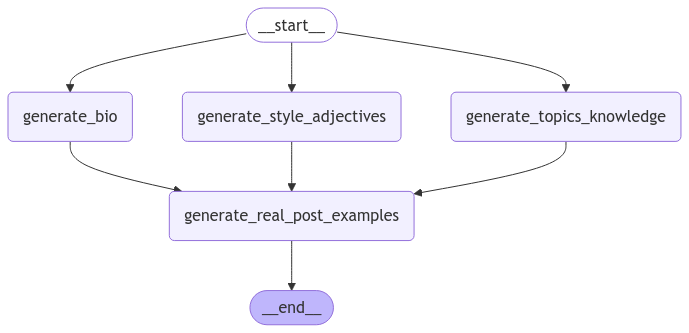

In [6]:
from IPython.display import Image, display
from eliza_generator_graph import eliza_generator_agent

display(Image(eliza_generator_agent.get_graph(xray=True).draw_mermaid_png()))

### Example call for autonome_graph

In [1]:
from eliza_generator_demo_input import eliza_generator_demo_input2
from eliza_generator_graph import eliza_generator_agent
from pprint import pprint
state = eliza_generator_agent.invoke(eliza_generator_demo_input2)

print("--------------------------------")
print("--------------------------------")
print("research:", pprint(state.get("research")))
print("--------------------------------")
print("raw:", pprint(state.get("raw")))
print("--------------------------------")
print("eliza:", pprint(state.get("eliza")))
print("--------------------------------")

{'bluesky_posts': [{'author_handle': 'markhamillofficial.bsky.social',
                    'embed': [{'alt': '',
                               'aspect_ratio': {'height': 720, 'width': 1280},
                               'fullsize': 'https://cdn.bsky.app/img/feed_fullsize/plain/did:plc:xyddpg6usmgh2t2jgf4e37yk/bafkreicnrdaopl274upv4ecujzn5pmwnrhanuemxup73t7fzcpxrqyasae@jpeg',
                               'thumb': 'https://cdn.bsky.app/img/feed_thumbnail/plain/did:plc:xyddpg6usmgh2t2jgf4e37yk/bafkreicnrdaopl274upv4ecujzn5pmwnrhanuemxup73t7fzcpxrqyasae@jpeg'},
                              {'alt': '',
                               'aspect_ratio': {'height': 1390, 'width': 895},
                               'fullsize': 'https://cdn.bsky.app/img/feed_fullsize/plain/did:plc:xyddpg6usmgh2t2jgf4e37yk/bafkreidzxjjy5nteekiquuukydv7vgkjszgmsmck2ohyrl7z2fw645yb5m@jpeg',
                               'thumb': 'https://cdn.bsky.app/img/feed_thumbnail/plain/did:plc:xyddpg6usmgh2t2jgf4e37yk/b

## Deployment graph demo

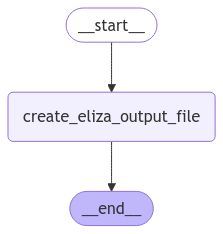

dict_values([[], 'Mark Cuban', {'adjectives': ['entrepreneurial', 'curious', 'strategic', 'tech-forward', 'opinionated', 'playful'], 'events': ['Mark Cuban was born in Pittsburgh, Pennsylvania, to a working-class Jewish family.', 'Cuban began his entrepreneurial journey by selling garbage bags to buy expensive sneakers.', 'During a Pittsburgh Post-Gazette strike, Cuban ran newspapers from Cleveland to Pittsburgh.', "Cuban graduated from Indiana University's Kelley School of Business with a Bachelor of Science in management.", 'Cuban moved to Dallas, Texas, initially working as a bartender and then a software salesperson.', 'Cuban sold MicroSolutions to CompuServe for $6 million, making approximately $2 million after taxes.', 'Cuban co-founded AudioNet (later Broadcast.com) with Todd Wagner, broadcasting live events over the internet.', 'Cuban and Wagner sold Broadcast.com to Yahoo! for $5.7 billion, making them instant billionaires.', 'Cuban purchased the Dallas Mavericks NBA team and 

In [4]:
from deployment_graph import deployment_agent
from langchain_core.messages import HumanMessage
from IPython.display import Image, display
from eliza_generator_demo_input import deployment_demo_input
from pprint import pprint

display(Image(deployment_agent.get_graph(xray=True).draw_mermaid_png()))
state = deployment_agent.invoke(deployment_demo_input)
pprint(state.values())

# Master graph



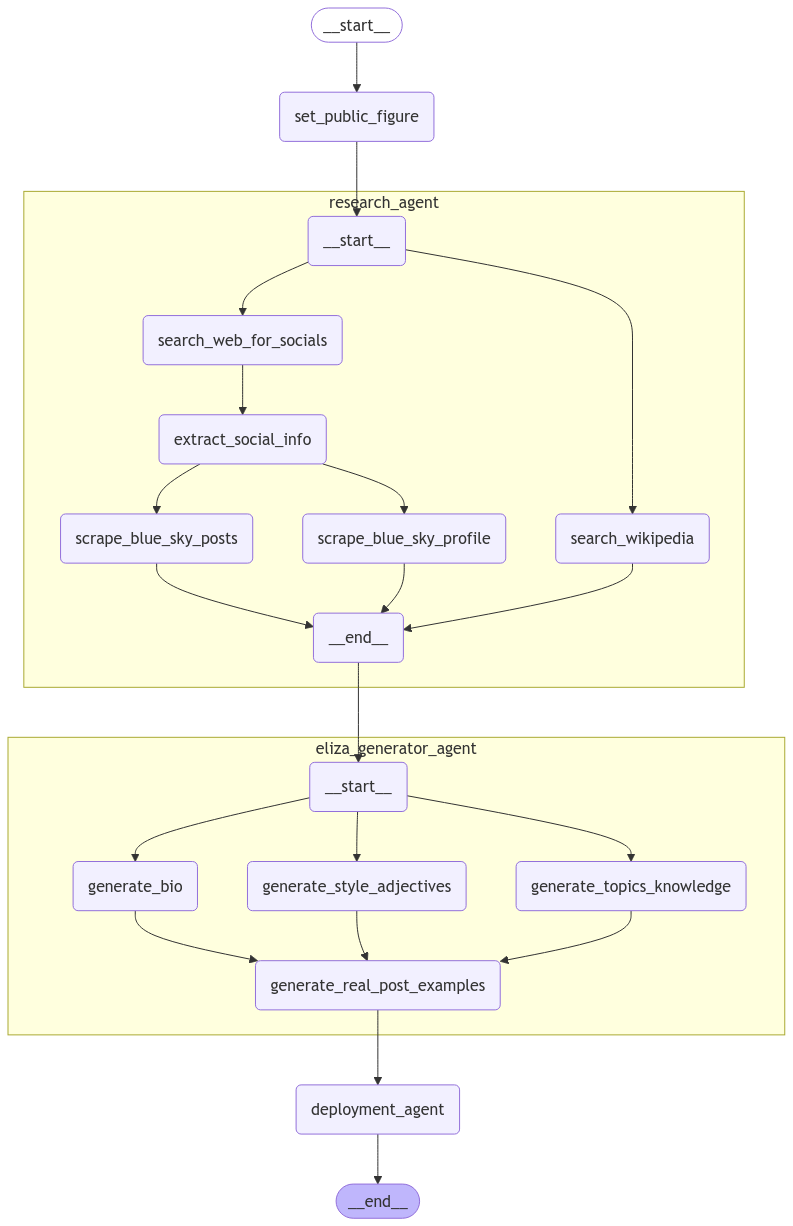

Preparing search queries for social media pages
Wikipedia search query: Mark Hamill actor Star Wars Luke Skywalker
type of social_search_queries.search_queries <class 'list'>
Searching for Mark Hamill official Facebook page
type of search_docs <class 'list'>
type of search_docs[0] <class 'dict'>
search_docs[0] {'url': 'https://www.facebook.com/OfficialQueenpage/about/', 'content': 'Mark Hamill Page is on Facebook. Join Facebook to connect with Mark Hamill Page and others you may know. Facebook gives people the power to share and makes the world more open and connected.'}
search_docs [{'url': 'https://www.facebook.com/OfficialQueenpage/about/', 'content': 'Mark Hamill Page is on Facebook. Join Facebook to connect with Mark Hamill Page and others you may know. Facebook gives people the power to share and makes the world more open and connected.'}, {'url': 'https://www.facebook.com/mark.hamill.fanpage.2025/', 'content': "Join Facebook to connect with Mark Hamill Fanpage and others you may

In [ ]:
from personality_downloader_graph import personality_downloader_agent

from langchain_core.messages import HumanMessage
from IPython.display import Image, display

display(Image(personality_downloader_agent.get_graph(xray=True).draw_mermaid_png()))
state = personality_downloader_agent.invoke(
    {"messages": [HumanMessage(content="Mark Hamill")]}
)
pprint(state.values)